## Convolutional Baseline modeling

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
tree_types = os.listdir('../data/image data/train')
X = []
y = []

for tree in tree_types:
    tree_path = os.path.join('../data/image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(128, 128))
            X.append(tf.image.rgb_to_grayscale(image))
            y.append([tree, disease])

In [3]:
val_x = []
val_y = []

for tree in tree_types:
    tree_path = os.path.join('../data/image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(128, 128))
            val_x.append(tf.image.rgb_to_grayscale(image))
            val_y.append([tree, disease])

In [4]:
X = np.asarray(X)
val_x = np.asarray(val_x)

In [5]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)

In [6]:
train_generator = ImageDataGenerator(rescale=1. / 255,
                                     rotation_range=45,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
val_generator = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=45,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_gen = train_generator.flow(X, y, batch_size=64)
val_gen = val_generator.flow(val_x, val_y, batch_size=64)

In [7]:
check_pointer = ModelCheckpoint(filepath='checkpoints/exp_conv_3.hdf5',
                                save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           min_delta=0)

In [9]:
X[0].shape

(128, 128, 1)

In [10]:
# alex net smaller version
base_conv = Sequential()

base_conv.add(InputLayer(input_shape=(128, 128, 1)))
base_conv.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer = 'he_normal', activation=relu))
base_conv.add(BatchNormalization())
base_conv.add(MaxPooling2D(pool_size=(2, 2)))
base_conv.add(Dropout(0.25))

base_conv.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer = 'he_normal', activation=relu))
base_conv.add(BatchNormalization())
base_conv.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer = 'he_normal', activation=relu))
base_conv.add(BatchNormalization())
base_conv.add(MaxPooling2D(pool_size=(2, 2)))
base_conv.add(Dropout(0.25))

base_conv.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer = 'he_normal', activation=relu))
base_conv.add(BatchNormalization())
base_conv.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer = 'he_normal', activation=relu))
base_conv.add(BatchNormalization())
base_conv.add(MaxPooling2D(pool_size=(2, 2)))
base_conv.add(Dropout(0.25))

base_conv.add(Flatten())
base_conv.add(Dense(units=1024, kernel_initializer = 'he_normal', activation=relu))
base_conv.add(Dropout(0.5))
base_conv.add(Dense(units=42, activation=sigmoid))

base_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)      

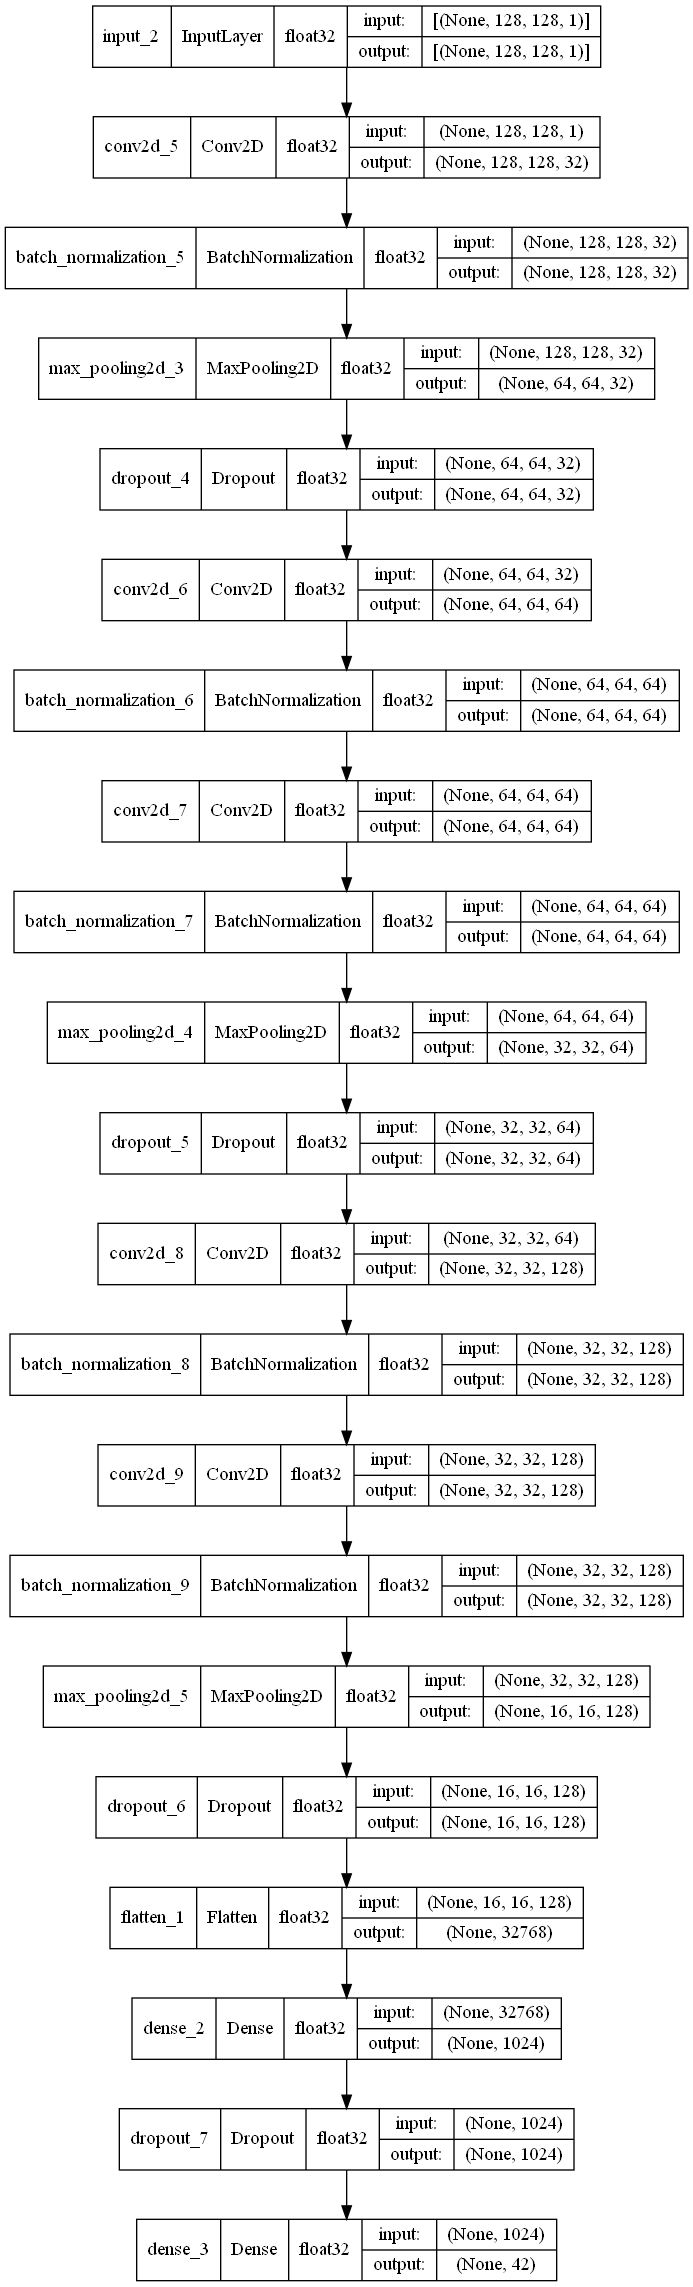

In [11]:
plot_model(base_conv,
           to_file='../models/exp_conv_3.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [12]:
base_conv.compile(optimizer=Adam(),
                  loss=binary_crossentropy,
                  metrics=['accuracy'])

history = base_conv.fit(train_gen,
                        epochs=50,
                        validation_data=val_gen,
                        callbacks=[check_pointer],
                        shuffle=True)

Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[64,32,32,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/dropout_5/dropout/random_uniform/RandomUniform
 (defined at c:\program files\python39\lib\site-packages\keras\layers\core\dropout.py:105)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_825423]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/dropout_5/dropout/random_uniform/RandomUniform:
In[0] sequential_1/dropout_5/dropout/Shape:

Operation defined at: (most recent call last)
>>>   File "c:\program files\python39\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\program files\python39\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\program files\python39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\program files\python39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\program files\python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\program files\python39\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\program files\python39\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\program files\python39\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\program files\python39\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\program files\python39\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\program files\python39\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\program files\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\program files\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "c:\program files\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\hewar\AppData\Local\Temp/ipykernel_5740/2141398986.py", line 5, in <module>
>>>     history = base_conv.fit(train_gen,
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\layers\core\dropout.py", line 111, in call
>>>     output = control_flow_util.smart_cond(training, dropped_inputs,
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
>>>     return tf.__internal__.smart_cond.smart_cond(
>>> 
>>>   File "c:\program files\python39\lib\site-packages\keras\layers\core\dropout.py", line 105, in dropped_inputs
>>>     return tf.nn.dropout(
>>> 

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(50))

sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[0])
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[0])
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[1])
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[1])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('training log/exp_conv_3_train_history.png')
plt.show()